In [1]:
import pyrosm
from matplotlib import pyplot

/mnt/c/Users/Alfred/CLionProjects/outbreak-sim/python/venv/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Get London's OpenStreetMap data
fp = pyrosm.get_data("London", update=True)
print(fp)

Downloaded Protobuf data 'London.osm.pbf' (66.79 MB) to:
'/tmp/pyrosm/London.osm.pbf'
/tmp/pyrosm/London.osm.pbf


In [3]:
# Initialize the OSM object 
osm = pyrosm.OSM(fp)

<AxesSubplot:>

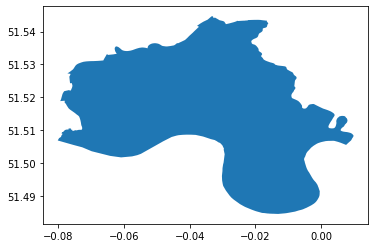

In [4]:
# Read all boundaries using the default settings
boundaries = osm.get_boundaries()

# pick a small subset for testing
boundary = osm.get_boundaries(name="London Borough of Tower Hamlets")
boundary.plot()
# import geopandas as gpd
# from shapely.geometry import box

# bbox = box(-0.0311018374,51.4945200196,-0.0039793398,51.5065151114)
# boundary = gpd.GeoDataFrame({'geometry': bbox}, index=[0])
# boundary.plot()

In [5]:
# Get the shapely geometry from GeoDataFrame
bbox_geom = boundary['geometry'].values[0]

# Initialise with bounding box
osm = pyrosm.OSM(fp, bounding_box=bbox_geom)

In [6]:
# get all residential buildings as well as ones without a specific tag
residential_filter = {"building": ["residential", "apartments", "flats", "house", "yes"]}
residential_buildings = osm.get_buildings(custom_filter=residential_filter)

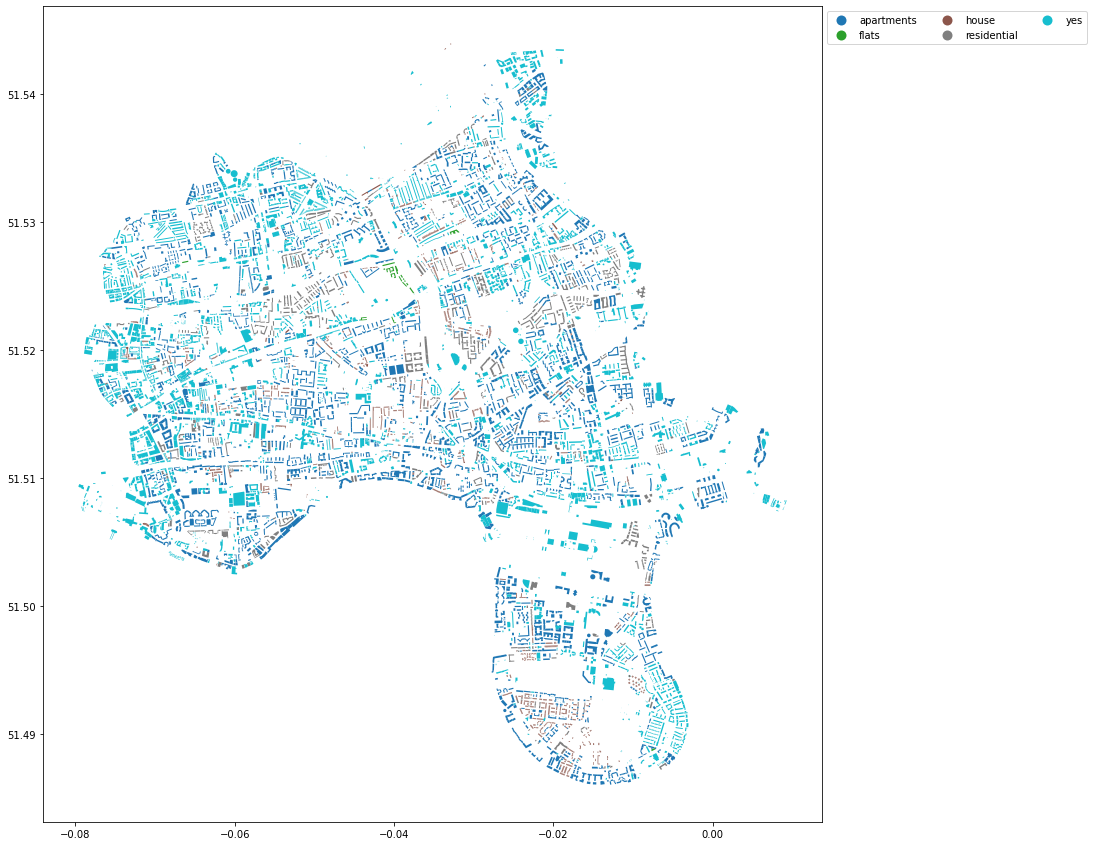

In [7]:
# Plot the buildings and specify colors according the type of the building
ax = residential_buildings.plot(column="building", figsize=(15,15), legend=True, legend_kwds=dict(loc='upper left', ncol=3, bbox_to_anchor=(1, 1)))

In [8]:
# residential_buildings.dtypes

In [9]:
# ax = residential_buildings.plot(column="building", legend=True, markersize=1, figsize=(14,8), legend_kwds=dict(loc='upper left', ncol=6, bbox_to_anchor=(1, 1)))

In [10]:
pois_filter = {"shop": True,"amenity": True, "leisure": True, "tourism": True}
pois = osm.get_pois(custom_filter=pois_filter)

In [11]:
# pois["shop"] = pois["shop"].fillna(' ')
# pois["amenity"] = pois["amenity"].fillna(' ')
# pois["leisure"] = pois["leisure"].fillna(' ')
# pois["tourism"] = pois["tourism"].fillna(' ')
# pois["poi_type"] = pois["amenity"] + pois["shop"] + pois["leisure"] + pois["tourism"] 
# ax = pois.plot(column="poi_type", legend=True, markersize=1, figsize=(14,8), legend_kwds=dict(loc='upper left', ncol=6, bbox_to_anchor=(1, 1)))

In [12]:
office_filter = {"office": True}
offices = osm.get_data_by_custom_criteria(custom_filter=office_filter)
print(len(offices))

287


In [13]:
# ax = offices.plot(column="office", figsize=(15,15), legend=True, legend_kwds=dict(loc='upper left', ncol=3, bbox_to_anchor=(1, 1)))

In [14]:
office_building_filter = {"building": ["office", "offices"]}
office_buildings = osm.get_buildings(custom_filter=office_building_filter)
print(len(office_buildings))

27


<AxesSubplot:>

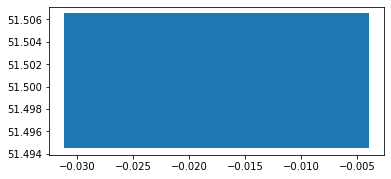

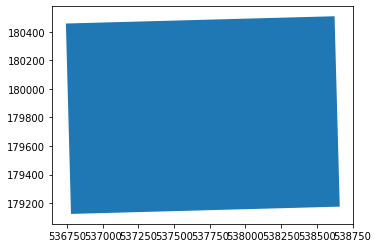

In [15]:
ORIGINAL_BOUNDS = bbox_geom.bounds
projected_boundary = boundary.copy()
projected_boundary = projected_boundary.set_crs("EPSG:4326")
projected_boundary = projected_boundary.to_crs(epsg=27700)
boundary.plot()
projected_boundary.plot()

In [16]:
trimmed_households = residential_buildings[['geometry']]
trimmed_workplaces = pois[['geometry']]
trimmed_offices = offices[['geometry']]
trimmed_office_buildings = office_buildings[['geometry']]

In [17]:
trimmed_work = trimmed_workplaces.append(trimmed_offices).append(trimmed_office_buildings)
trimmed_work = trimmed_work.reset_index()

In [23]:
def convert_to_x_y(in_df, epsg):
    out_df = in_df.to_crs(epsg=epsg)
    
    projected_boundary = boundary.copy()
    projected_boundary = projected_boundary.set_crs("EPSG:4326")
    projected_boundary = projected_boundary.to_crs(epsg=epsg)
    bounds = projected_boundary.bounds
    minx = bounds.loc[bounds.index[0], 'minx']
    maxx = bounds.loc[bounds.index[0], 'maxx']
    miny = bounds.loc[bounds.index[0], 'miny']
    maxy = bounds.loc[bounds.index[0], 'maxy']
    
    out_df['x'] = out_df.geometry.centroid.x
    out_df['y'] = out_df.geometry.centroid.y
    out_df['x'] = (out_df['x'] - minx) / (maxx - minx)
    out_df['y'] = (out_df['y'] - miny) / (maxy - miny)
    return out_df[['x', 'y']]

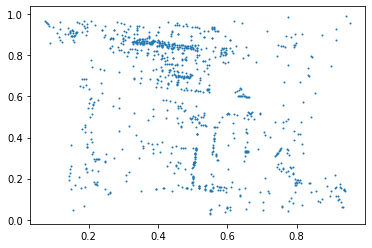

In [24]:
projected_workplaces = convert_to_x_y(trimmed_work, 27700)
pyplot.scatter(projected_workplaces[['x']], projected_workplaces[['y']], s=1)
pyplot.show()

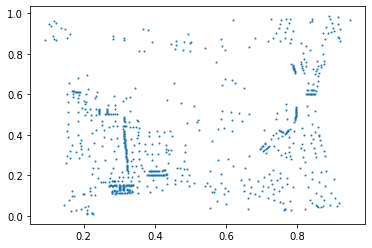

In [25]:
projected_households = convert_to_x_y(trimmed_households, 27700)
pyplot.scatter(projected_households[['x']], projected_households[['y']], s=1)
pyplot.show()

In [26]:
projected_workplaces.to_csv('./data/sm_workplaces.csv', columns=['x', 'y'], sep='|', header=['x', 'y'], index=False)
projected_households.to_csv('./data/sm_households.csv', columns=['x', 'y'], sep='|', header=['x', 'y'], index=False)